### Problem Set #5
#### MACS 30100, Dr. Evans
#### Name: Xiang Zhang
#### snzhang@uchicago.edu

### Problem one: Multinomial logistic regression and cross validation
#### (a)

In [1]:
import numpy as np
import pandas as pd
from pandas import Series, DataFrame

from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
from sklearn import metrics 
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import LeaveOneOut, KFold
from pylab import rcParams
import statsmodels.api as sm
from scipy.interpolate import make_lsq_spline, BSpline
from scipy.interpolate import LSQUnivariateSpline

import matplotlib.pyplot as plt
import seaborn as sb

C:\Users\Xiang Zhang\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\Xiang Zhang\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
url = "https://raw.githubusercontent.com/UC-MACSS/persp-model_W18/master/ProblemSets/PS5/data/strongdrink.txt"
df = pd.read_csv(url)
df.head()

,cultivar,alco,malic,ash,alk,magn,tot_phen,flav,nonfl_phen,proanth,color_int,hue,OD280rat,proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


In [3]:
xvar = ["alco", "malic", "tot_phen", "color_int"]
X = df.loc[:, xvar]
y = df.loc[:, 'cultivar']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=20)

MultLogReg = LogisticRegression(multi_class='multinomial',
                                solver='newton-cg')
MultLogReg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=1, penalty='l2', random_state=None, solver='newton-cg',
          tol=0.0001, verbose=0, warm_start=False)

In [6]:
coef = pd.DataFrame(MultLogReg.coef_[0:2], index = ["cultivar = 1", "cultivar = 2"], columns = xvar)
coef["Intercept"] = MultLogReg.intercept_[0:2]
print("The estimated coefficients for j = 1 and j = 2 are listed below:")
coef

The estimated coefficients for j = 1 and j = 2 are listed below:


,alco,malic,tot_phen,color_int,Intercept
cultivar = 1,1.700403,-0.265605,1.223894,0.022756,-24.010989
cultivar = 2,-1.468044,-0.333053,0.664012,-0.922712,22.802446


In [7]:
y_pred = MultLogReg.predict(X_test)
print(classification_report(y_test, y_pred))
print("The error rate for j = 1 is 0.13 and the error rate for j=2 is 0")

             precision    recall  f1-score   support

          1       0.87      1.00      0.93        13
          2       1.00      0.90      0.95        21
          3       1.00      1.00      1.00        10

avg / total       0.96      0.95      0.96        44

The error rate for j = 1 is 0.13 and the error rate for j=2 is 0


Cultivar 2 and 3 have 100% precision, but Cultivar 3 has higher recall score. So Cultivar 3 is the model best at predicting. It is not the one with most observations.

#### (b) Leave one out

In [15]:
Xvars = df[xvar].values
yvals = df['cultivar'].values

N_loo = df.shape[0]

loo = LeaveOneOut()
loo.get_n_splits(Xvars)
MSE_vec = np.zeros(N_loo)

y_tests = np.zeros(N_loo)
y_preds = np.zeros(N_loo)

for train_index, test_index in loo.split(Xvars):
    X_train, X_test = Xvars[train_index], Xvars[test_index]
    y_train, y_test = yvals[train_index], yvals[test_index]
    LogReg = LogisticRegression(multi_class='multinomial',
                                solver='newton-cg')
    LogReg.fit(X_train, y_train)
    y_pred = LogReg.predict(X_test)
    
    y_tests[test_index] = y_test
    y_preds[test_index] = y_pred
    MSE_vec[test_index] = (y_test - y_pred) ** 2

MSE_loo = MSE_vec.mean()
MSE_loo_std = MSE_vec.std()
print('test estimate MSE loocv=', MSE_loo,
      ', test estimate MSE standard err=', MSE_loo_std)

print(classification_report(y_tests, y_preds))

test estimate MSE loocv= 0.0965909090909 , test estimate MSE standard err= 0.394262505894
             precision    recall  f1-score   support

        1.0       0.90      0.93      0.92        59
        2.0       0.91      0.90      0.91        71
        3.0       0.96      0.93      0.95        46

avg / total       0.92      0.92      0.92       176



We can see from the table above that the error rate for Cultivar 1 is 10%, the error rate for Cultivar 2 is 9%, and the error rate for CUltivar 3 is 4%. The overall error rate is 8%. Compared with the answer from 1(a), this model has better precision for Cultivar 1, but worse precision for Cultivar 2 and 3. Also, the overall precision is lower.

#### (c) k-fold

In [17]:
k = 4
kf = KFold(n_splits=k, random_state=10, shuffle=True)
kf.get_n_splits(Xvars)

MSE_vec_kf = np.zeros(k)
y_tests = np.array([])
y_preds = np.array([])

k_ind = int(0)
for train_index, test_index in kf.split(Xvars):
    X_train, X_test = Xvars[train_index], Xvars[test_index]
    y_train, y_test = yvals[train_index], yvals[test_index]
    LogReg = LogisticRegression(multi_class='multinomial',
                                solver='newton-cg')
    LogReg.fit(X_train, y_train)
    y_pred = LogReg.predict(X_test)
    y_tests = np.append(y_tests, y_test)
    y_preds = np.append(y_preds, y_pred)
    MSE_vec_kf[k_ind] = ((y_test - y_pred) ** 2).mean()
    k_ind += 1

MSE_kf = MSE_vec_kf.mean()
MSE_kf_std = MSE_vec_kf.std()
print('test estimate MSE k-fold=', MSE_kf,
      'test estimate MSE standard err=', MSE_kf_std)

print(classification_report(y_tests, y_preds))

test estimate MSE k-fold= 0.107954545455 test estimate MSE standard err= 0.0742994138104
             precision    recall  f1-score   support

        1.0       0.87      0.93      0.90        59
        2.0       0.91      0.87      0.89        71
        3.0       0.96      0.93      0.95        46

avg / total       0.91      0.91      0.91       176



We can see from the table above that the error rate for Cultivar 1 is 13%, the error rate for Cultivar 2 is 9%, and the error rate for CUltivar 3 is 4%. The overall error rate is 9%. Compared with the answer from 1(a), this model has the same precision for Cultivar 1, but worse precision for Cultivar 2 and 3. Also, the overall precision is lower. Compared with the answer from 1(b), this model has worse precision for Cultivar 1, but same precision for Cultivar 2 and 3. Also, the overall precision is lower.

### 2. Splines and interpolation

In [19]:
url = 'https://raw.githubusercontent.com/UC-MACSS/persp-model_W18/master/ProblemSets/PS5/data/CoolIndex.txt'
df = pd.read_csv(url,  names = ['age', "CI"])
df.head()

,age,CI
0,11.0,10.981602
1,11.0,11.364925
2,11.0,10.190227
3,11.0,9.903725
4,11.0,8.997918


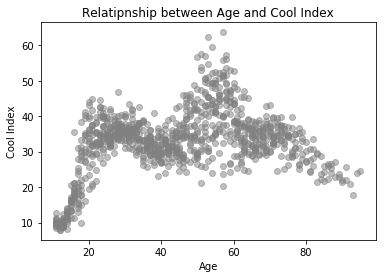

In [20]:
x = np.array(df['age'])
y = np.array(df['CI'])

plt.scatter(x, y, c = "gray", alpha=0.5)
plt.xlabel("Age")
plt.ylabel("Cool Index")
plt.title("Relatipnship between Age and Cool Index")
plt.show()

In [21]:
CI = df['CI']
age = df['age']
age_bin1 = ((age >= 11) & (age < 22)).astype(int)
age_bin2 = ((age >= 22) & (age < 40)).astype(int)
age_bin3 = ((age >= 40) & (age < 59)).astype(int)
age_bin4 = ((age >= 59) & (age < 77)).astype(int)
age_bin5 = ((age >= 77) & (age <= 95)).astype(int)

X_step = pd.DataFrame(dict(age_bin1 = age_bin1, age_bin2 = age_bin2,
                           age_bin3 = age_bin3, age_bin4 = age_bin4,
                           age_bin5 = age_bin5))
X_step.describe()

reg2 = sm.OLS(endog = CI, exog = X_step, missing='drop')
reg2_results = reg2.fit()

In [22]:
df.CI_stepwise = 0
df.loc[(df.age.astype(int) >= 11) & (df.age.astype(int) < 22), 'CI_stepwise'] = reg2_results.params[0]
df.loc[(df.age.astype(int) >= 22) & (df.age.astype(int) < 40), 'CI_stepwise'] = reg2_results.params[1]
df.loc[(df.age.astype(int) >= 40) & (df.age.astype(int) < 59), 'CI_stepwise'] = reg2_results.params[2]
df.loc[(df.age.astype(int) >= 59) & (df.age.astype(int) < 77), 'CI_stepwise'] = reg2_results.params[3]
df.loc[(df.age.astype(int) >= 77) & (df.age.astype(int) <=95), 'CI_stepwise'] = reg2_results.params[4]

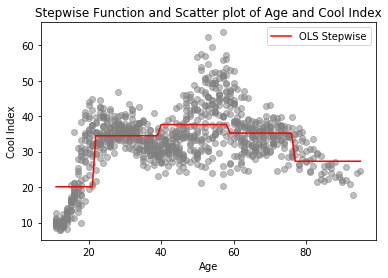

In [23]:
plt.scatter(x, y, c = "gray", alpha=0.5)
plt.xlabel("Age")
plt.ylabel("Cool Index")
plt.title("Stepwise Function and Scatter plot of Age and Cool Index")
plt.plot(df['age'], df['CI_stepwise'], c = 'r', label = 'OLS Stepwise')
plt.legend()
plt.show()

In [24]:
print(reg2_results.summary())
print("The estimated step function values for each bin is: 20.1025, 34.4758, 37.6351, 35.2254, 27.2964")

                            OLS Regression Results                            
Dep. Variable:                     CI   R-squared:                       0.429
Model:                            OLS   Adj. R-squared:                  0.427
Method:                 Least Squares   F-statistic:                     178.7
Date:                Sun, 18 Feb 2018   Prob (F-statistic):          3.73e-114
Time:                        22:58:04   Log-Likelihood:                -3214.5
No. Observations:                 956   AIC:                             6439.
Df Residuals:                     951   BIC:                             6463.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
age_bin1      20.1025      0.562     35.746      0.0

The predicted coolness of a 73-year old from the stepwise function is 35.2254

#### (c) linear spline 

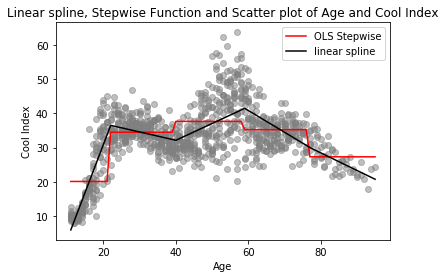

In [26]:
knots = [22, 40, 59, 77]
k = 1

spl_df = LSQUnivariateSpline(age.values, CI.values, knots, k=1)

age_vec = np.linspace(age.values.min(), age.values.max(), 1000)

plt.scatter(x, y, c = "gray", alpha=0.5)
plt.xlabel("Age")
plt.ylabel("Cool Index")
plt.title("Linear spline, Stepwise Function and Scatter plot of Age and Cool Index")
plt.plot(df['age'], df['CI_stepwise'], c = 'r', label = 'OLS Stepwise')
plt.plot(age_vec, spl_df(age_vec), c = 'k', label = 'linear spline')
plt.legend()
plt.show()

In [28]:
print("The predicted coolness of a 73-year old is:", spl_df(np.array([73])))

The predicted coolness of a 73-year old is: [ 32.53683239]


#### (d) Cubic spline

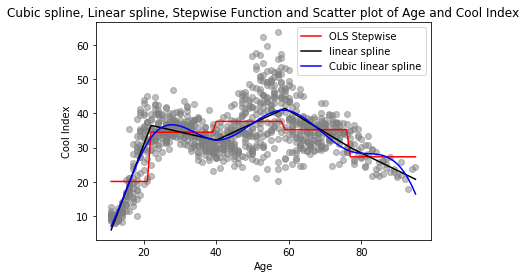

In [32]:
knots = [22, 40, 59, 77]
k = 1

cub_spl_df = LSQUnivariateSpline(age.values, CI.values, knots, k = 3)

age_vec = np.linspace(age.values.min(), age.values.max(), 1000)

plt.scatter(x, y, c="gray", alpha=0.5)
plt.xlabel("Age")
plt.ylabel("Cool Index")
plt.title("Cubic spline, Linear spline, Stepwise Function and Scatter plot of Age and Cool Index")
plt.plot(df['age'], df['CI_stepwise'], c = 'r', label = 'OLS Stepwise')
plt.plot(age_vec, spl_df(age_vec), c = 'k', label = 'linear spline')
plt.plot(age_vec, cub_spl_df(age_vec), c = 'b', label = 'Cubic linear spline')
plt.legend()
plt.show()

In [31]:
print("The predicted coolness of a 73-year old is:", cub_spl_df(np.array([73])))

The predicted coolness of a 73-year old is: [ 31.26242939]


My answer to this probalem set ends here, thanks for your attention!